In [1]:
# The library you need to install
# ! pip install -r requirements.txt

In [2]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils.augmentations import get_default_transform
from utils import creating_dataset

# Dataset loading & inspection
This notebook shows how to load the datasets used in this challenge and provides some basic statistics about them.

Note that the data includes EMG signal from 8 electrodes in the EMG armband, the predicted variables are the angle of 20 joints in the hand. Inputs are sampled at 200Hz, but the  outputs are intended to be at a subsampled rate of 25Hz (more on that in other notebooks).

Data was acquired in "healthy" and "amputant" subjects (i.e. with limb loss) using the EMG armband in either the left or right arm. 
Your model's predictions will be evaluated on data from one of the two amputant subjects (fedya), but you can use any and all provided data for training your model. For simplicity, the data has been divided in `training` and `test` subsets (not all subjects have `test` data) to evaluate your model's performance during training. The final submission data is held separate and only used when preparing the submission.csv file (see 04_submit_predictions.ipynb).

### Load data
Start by defining a variable to keep track of where the data is saved on your computer and a set of parameters for selecting which data to load. 

In [3]:
# DATA_PATH = r"F:\Dropbox (Personal)\BCII\BCI Challenges\2024 ALVI EMG Decoding\dataset_v2_blocks\dataset_v2_blocks"
# DATA_PATH = "/media/lutetia/Extreme SSD/EMG_Yun/bci-initiative-alvi-hci-challenge/dataset_v2_blocks/dataset_v2_blocks"
DATA_PATH = "C:\GitHub\BCI_ALVI_challenge\dataset_v2_blocks\dataset_v2_blocks"

You can decide which data to load (e.g. from both `health` and `amputant` subjects). 
The `test_dataset_list` specifies which subset of the data should be used as test set, and it shouldn't change. You can, however, play around with training your model on different subsets of the available training data. 

You can also define a set of `transform` functions to apply to the data before feeding it to the model, or load the default ones.

In [4]:
data_paths = dict(
    datasets=[DATA_PATH],
    hand_type = ['left', 'right'], # [left, 'right']
    human_type = ['health', 'amputant'], # [amputant, 'health']
    test_dataset_list = ['fedya_tropin_standart_elbow_left']  # don't change this !
)

# define a config object to keep track of data variables
data_config = creating_dataset.DataConfig(**data_paths)

# get transforms
p_transform = 0.1  # probability of applying the transform
transform = get_default_transform(p_transform)

# load the data
train_dataset, test_dataset = creating_dataset.get_datasets(data_config, transform=transform)


Getting val datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Getting train datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Number of moves: 70 | Dataset: valery_first_standart_elbow_left
Reorder this dataset valery_first_standart_elbow_left True
Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
Number of moves: 72 | Dataset: anna_makarova_standart_elbow_left
Reorder this dataset anna_makarova_standart_elbow_left True
Number of moves: 62 | Dataset: artem_snailbox_standart_elbow_left
Reorder this dataset artem_snailbox_standart_elbow_left True
Number of moves: 144 | Dataset: matthew_antonov_standart_elbow_left
Reorder this dataset matthew_antonov_standart_elbow_left True
Number of moves: 144 | Dataset: misha_korobok_standart_elbow_left
Reorder this da

### Inspect the data

`train_dataset` and `test_dataset` are instances of the `torch.utils.data.ConcatDataset` class. 


The following code shows the number of batches in each set as well as the size of input and outputs. 
Note that inputs are of shape `n_channels x batch_size` while the outputs are of shape `n_angles x downsampled_batchs_size` where `downsampled_batch_size = batch_size / 200 * 25` to account for downsampling of predictions. 

In [ ]:
print(f"Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")

X, Y = train_dataset[0]
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Train dataset size: 99990, Test dataset size: 792
X shape: (8, 256), Y shape: (20, 32)


You can also generate a video of the hand movements.

In [19]:
from utils.hand_visualize import Hand, save_animation
from utils.quats_and_angles import get_quats
import numpy as np


batches = [train_dataset[i] for i in range(10)]
Y = np.concatenate([b[1] for b in batches], axis=1)
quats = get_quats(Y)

hand_gt = Hand(quats)
ani = hand_gt.visualize_all_frames()
save_animation(ani, 'test_vis.gif', fps=500,)   # this will save a .gif file

X shape (n_channels x batch_size) : (8, 256),
Y shape (n_angles x downsampled_batchs_size): (20, 32)
EMG Signal Statistics:
Mean: [-0.00612994 -0.01631511 -0.00595306 -0.00400577 -0.00307752  0.00406105
 -0.00395527 -0.00090029]
Standard Deviation: [0.16200307 0.20281243 0.1346999  0.09521595 0.10024224 0.37453213
 0.46476775 0.18760505]
Min: [-0.9060511  -0.47136715 -0.61485463 -0.30115655 -0.37686    -1.
 -1.         -0.5169728 ]
Max: [0.6768535  0.89717025 0.5166002  0.3596635  0.5232307  1.
 1.         0.6066779 ]


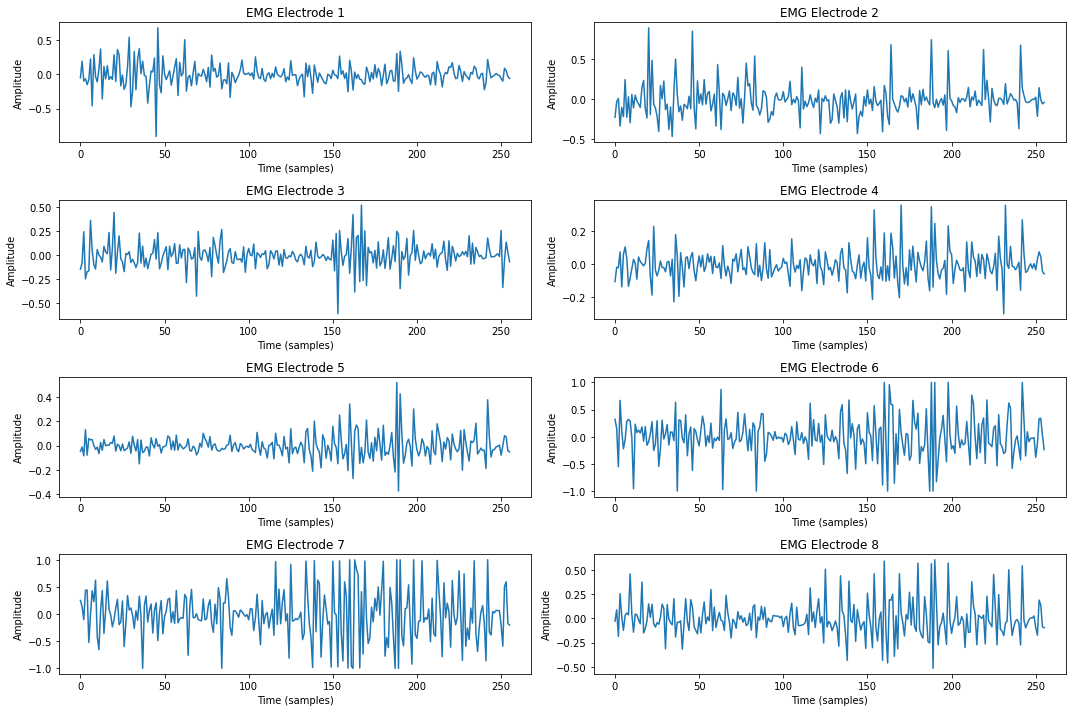

In [40]:
# The above code is provided by the authors of the dataset
# The following code is provided by me to further analyze the dataset.

#X, Y = train_dataset[0]
# X is the EMG signal, Y is the target joint angles
print(f"X shape (n_channels x batch_size) : {X.shape},\nY shape (n_angles x downsampled_batchs_size): {Y.shape}")

# Here are more information about the dataset
# Basic statistics for EMG signals
print("EMG Signal Statistics:")
print(f"Mean: {X.mean(axis=1)}")
print(f"Standard Deviation: {X.std(axis=1)}")
print(f"Min: {X.min(axis=1)}")
print(f"Max: {X.max(axis=1)}")

# Plot EMG signals from each electrode
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(8):  # 8 electrodes
    plt.subplot(4, 2, i+1)
    plt.plot(X[i, :])  # Plot the signal from each electrode
    plt.title(f"EMG Electrode {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

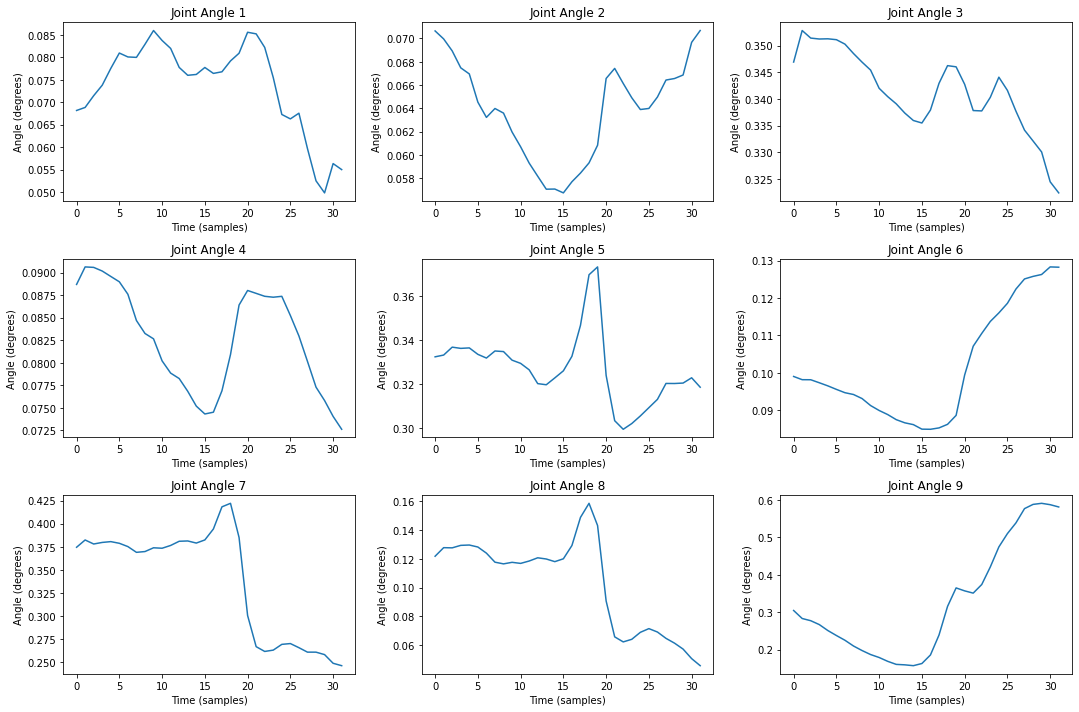

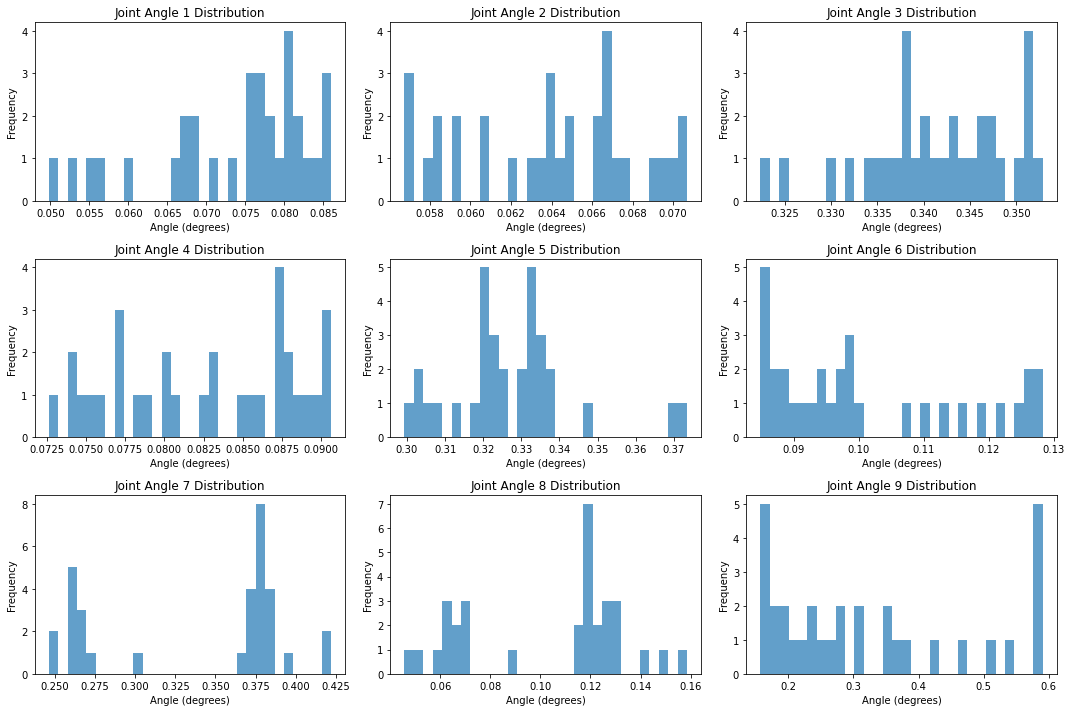

In [ ]:
# Analyze joint angles
plt.figure(figsize=(15, 10))
for i in range(min(9, Y.shape[0])):  # Plot first 9 joint angles
    plt.subplot(3, 3, i+1)
    plt.plot(Y[i, :]) # Plot the joint angle
    plt.title(f"Joint Angle {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Angle (degrees)")
plt.tight_layout()
plt.show()

# Distribution of joint angles
plt.figure(figsize=(15, 10))
for i in range(min(9, Y.shape[0])):
    plt.subplot(3, 3, i+1)
    plt.hist(Y[i, :], bins=30, alpha=0.7)
    plt.title(f"Joint Angle {i+1} Distribution")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

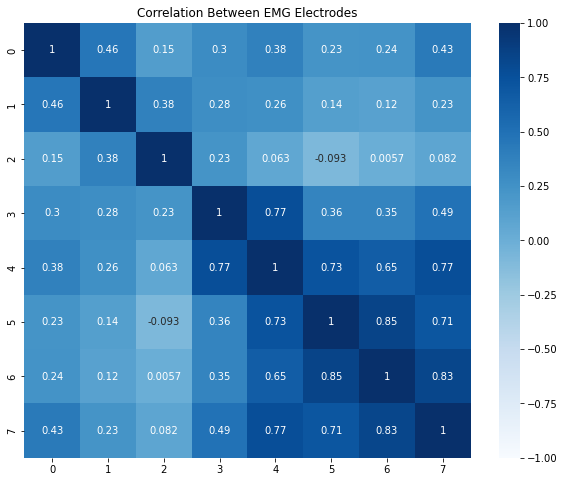

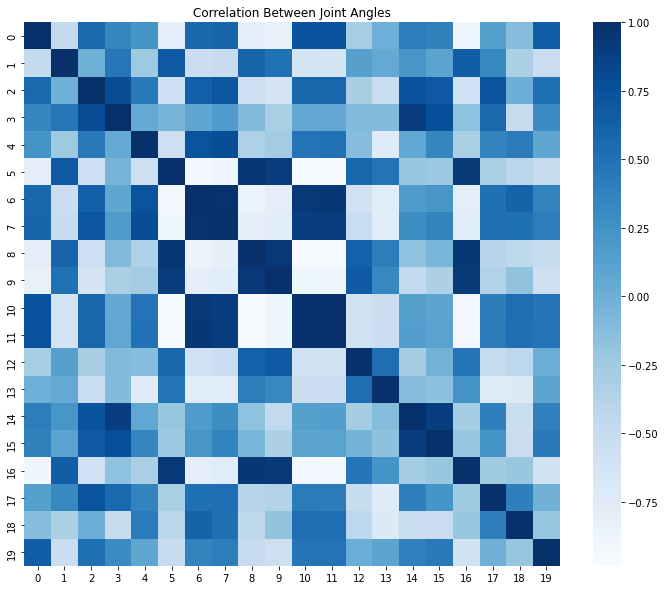

In [45]:
# Correlation between EMG electrodes
import seaborn as sns
import pandas as pd
import numpy as np

# Sample a portion of the data for correlation analysis
sample_size = 1000 # Plot first 1000 samples (5 seconds at 200Hz)
X_sample = X[:, :sample_size]

# Electrode correlation
electrode_corr = pd.DataFrame(np.corrcoef(X_sample))
plt.figure(figsize=(10, 8))
sns.heatmap(electrode_corr, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title("Correlation Between EMG Electrodes")
plt.show()

# Joint angle correlation
if Y.shape[1] > 0:  # Ensure Y has data
    Y_sample = Y[:, :min(Y.shape[1], 200)]  # Sample first 200 points or less
    joint_corr = pd.DataFrame(np.corrcoef(Y_sample))
    plt.figure(figsize=(12, 10))
    sns.heatmap(joint_corr, annot=False, cmap='Blues')
    plt.title("Correlation Between Joint Angles")
    plt.show()

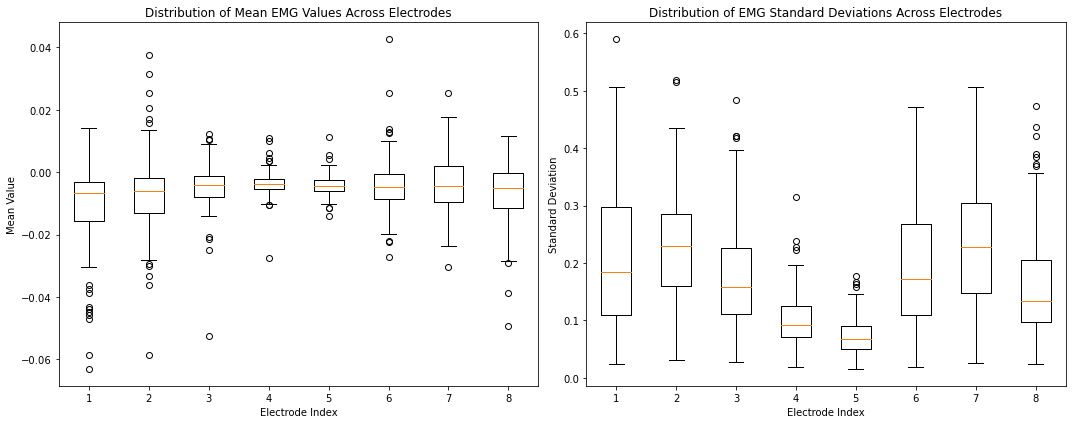

In [46]:
# Collect statistics across multiple data points
n_samples = min(100, len(train_dataset))
emg_means = []
emg_stds = []
angle_means = []
angle_stds = []

for i in range(n_samples):
    X, Y = train_dataset[i]
    emg_means.append(X.mean(axis=1))
    emg_stds.append(X.std(axis=1))
    angle_means.append(Y.mean(axis=1))
    angle_stds.append(Y.std(axis=1))

emg_means = np.array(emg_means)
emg_stds = np.array(emg_stds)
angle_means = np.array(angle_means)
angle_stds = np.array(angle_stds)

# Plot electrode-wise mean and std across samples
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.boxplot(emg_means)
plt.title("Distribution of Mean EMG Values Across Electrodes")
plt.xlabel("Electrode Index")
plt.ylabel("Mean Value")

plt.subplot(1, 2, 2)
plt.boxplot(emg_stds)
plt.title("Distribution of EMG Standard Deviations Across Electrodes")
plt.xlabel("Electrode Index")
plt.ylabel("Standard Deviation")
plt.tight_layout()
plt.show()